## Import Libraries

In [1]:
import gymnasium as gym
import gym_puddle

from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.dqn import MlpPolicy as DQNPolicy
from stable_baselines3.ppo import MlpPolicy as PPOPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2


## Puddle World Details

In [66]:
env = gym.make("PuddleWorld-v0")

print("start position:", env.get_wrapper_attr("start"))
print("goal position:", env.get_wrapper_attr("goal"))
print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
print("action noise:", env.get_wrapper_attr("noise"))
print("agent's thrust:", env.get_wrapper_attr("thrust"))
print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
print("action space:", env.get_wrapper_attr("actions"))
print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)


In [71]:
env.action_space.sample()

1

## Visualization Function

In [72]:

#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "/results/video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1

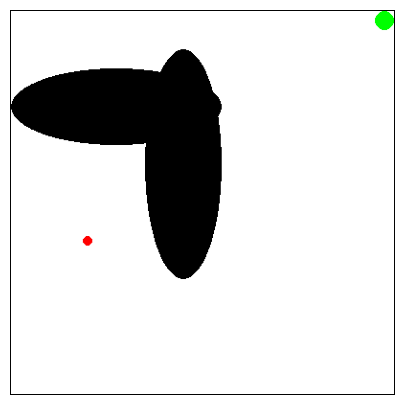

In [73]:
obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(image)

## 2.1 Accessing Different Environment Configurations


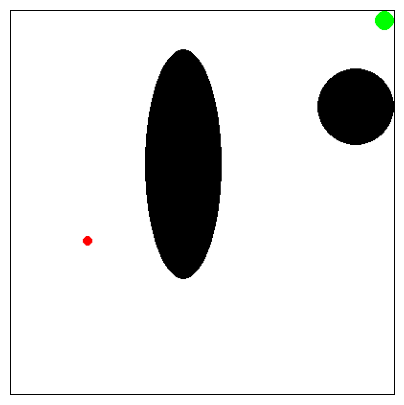

In [74]:
json_file = f"/Users/hadiaghazadeh/Library/CloudStorage/OneDrive-UniversityofCalgary/@upperboundCompetition/gym-puddle/gym_puddle/env_configs/pw3.json"

with open(json_file) as f:
  env_setup = json.load(f)

env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)

obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))

online_rendering(image)

In [79]:
env.action_space.sample()

2

## Developing the Agents



### PPO Model

In [47]:
dqn_model = PPO(PPOPolicy, env, verbose=1)
dqn_model.learn(total_timesteps=int(1e5))
dqn_model.save("ppo_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 8640 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.29e+03     |
|    ep_rew_mean          | -4.66e+04    |
| time/                   |              |
|    fps                  | 5310         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0012785005 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | -8.23e-06    |
|    learning_rate        | 0.0003       |
|    los

In [49]:
ppo_model = PPO.load("ppo_model")

obs, info = env.reset()

# Create an empty list to store the frames
frames = []
episode_rewards = []

for episode in range(1):
  total_reward = 0
  done = False
  num_steps = 0

  while not done and num_steps <=1000: # to avoid infinite loops for the untuned DQN we set a truncation limit, but you should make your agent sophisticated enough to avoid infinite-step episodes
      num_steps +=1
      action, _states = ppo_model.predict(obs)
      observation, reward, done, trunc, info = env.step(action)
      total_reward += reward
      if done == True:
        print("here")

      image = env.render()
      frames.append(image)

      if done:
        print(f"total reward in this episode: {total_reward}")
        episode_rewards.append(total_reward)
        total_reward = 0
        break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "ppo.mp4")


no episode finished in this run.


### Q-Learning with Tile coding

In [48]:

import numpy as np
import json

# Assuming necessary functions from your prior code
def create_tiling(feat_range, bins, offset):
    return np.linspace(feat_range[0], feat_range[1], bins + 1)[1:-1] + offset

def create_tilings(feature_ranges, number_tilings, bins, offsets):
    tilings = []
    for tile_i in range(number_tilings):
        tiling = [create_tiling(feature_ranges[feat_i], bins[tile_i][feat_i], offsets[tile_i][feat_i])
                  for feat_i in range(len(feature_ranges))]
        tilings.append(tiling)
    return np.array(tilings)

def get_tile_coding(feature, tilings):
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = [np.digitize(feature[i], tiling[i]) for i in range(num_dims)]
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

class QValueFunction:
    def __init__(self, tilings, num_actions, lr):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.num_actions = num_actions
        self.lr = lr
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling) for tiling in self.tilings]
        self.q_tables = [np.zeros(shape=(*state_size, num_actions)) for state_size in self.state_sizes]

    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)
        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            value += q_table[tuple(coding) + (action,)]
        return value / self.num_tilings

    def update(self, state, action, target):
        state_codings = get_tile_coding(state, self.tilings)
        for coding, q_table in zip(state_codings, self.q_tables):
            q_value = q_table[tuple(coding) + (action,)]
            q_table[tuple(coding) + (action,)] += self.lr * (target - q_value)

def simulate_episode(env, q_func, eps, gamma):
    state, _ = env.reset()
    total_reward = 0
    done = False
    trunc = False  # To capture truncation condition as well

    while not done and not trunc:  # We check both done and truncated
        if np.random.random() < eps:
            action = env.action_space.sample()
        else:
            q_values = [q_func.value(state, i) for i in range(env.action_space.n)]
            action = np.argmax(q_values)

        next_state, reward, done, trunc, _ = env.step(action)  # Update here
        total_reward += reward
        
        if not done and not trunc:  # Consider next state only if not done and not truncated
            next_q_values = [q_func.value(next_state, i) for i in range(env.action_space.n)]
            max_next_q = max(next_q_values)
        else:
            max_next_q = 0
        
        target = reward + gamma * max_next_q
        q_func.update(state, action, target)
        state = next_state
    
    return total_reward


tilings = create_tilings([env.observation_space.low, env.observation_space.high], 3,
                        [[8, 8], [8, 8], [8, 8]], [[0, 0], [0.2, 0.2], [0.4, 0.4]])
q_func = QValueFunction(tilings, env.action_space.n, 0.01)

num_episodes = 500
eps = 0.1
gamma = 0.95

for i in range(num_episodes):
    reward = simulate_episode(env, q_func, eps, gamma)
    if (i + 1) % 20 == 0:
        print(f"Episode {i + 1}: Total Reward {reward}")

env.close()



Episode 20: Total Reward -10531.31961984268
Episode 40: Total Reward -3078.436473608867
Episode 60: Total Reward -1888.837715306261
Episode 80: Total Reward -4131.092905098181
Episode 100: Total Reward -4154.771033225917
Episode 120: Total Reward -4090.0739545055976
Episode 140: Total Reward -375.2643107378943
Episode 160: Total Reward -41
Episode 180: Total Reward -1997.2574867868154
Episode 200: Total Reward -3152.2081793562215
Episode 220: Total Reward -2694.576258076341
Episode 240: Total Reward -3492.554895184431
Episode 260: Total Reward -2542.114953129988
Episode 280: Total Reward -494
Episode 300: Total Reward -1686.6171462261657
Episode 320: Total Reward -149
Episode 340: Total Reward -573
Episode 360: Total Reward -5428.566657706091
Episode 380: Total Reward -2567.4999221982853
Episode 400: Total Reward -77
Episode 420: Total Reward -4261.2542544197495
Episode 440: Total Reward -60
Episode 460: Total Reward -4032.967623579161
Episode 480: Total Reward -362
Episode 500: Total 

## With Decay e-greedy

In [38]:

import numpy as np
import json

# Assuming necessary functions from your prior code
def create_tiling(feat_range, bins, offset):
    return np.linspace(feat_range[0], feat_range[1], bins + 1)[1:-1] + offset

def create_tilings(feature_ranges, number_tilings, bins, offsets):
    tilings = []
    for tile_i in range(number_tilings):
        tiling = [create_tiling(feature_ranges[feat_i], bins[tile_i][feat_i], offsets[tile_i][feat_i])
                  for feat_i in range(len(feature_ranges))]
        tilings.append(tiling)
    return np.array(tilings)

def get_tile_coding(feature, tilings):
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = [np.digitize(feature[i], tiling[i]) for i in range(num_dims)]
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

class QValueFunction:
    def __init__(self, tilings, num_actions, lr, initial_epsilon, epsilon_decay):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.num_actions = num_actions
        self.lr = lr
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling) for tiling in self.tilings]
        self.q_tables = [np.zeros(shape=(*state_size, num_actions)) for state_size in self.state_sizes]
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay

    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)
        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            value += q_table[tuple(coding) + (action,)]
        return value / self.num_tilings

    def update(self, state, action, target):
        state_codings = get_tile_coding(state, self.tilings)
        for coding, q_table in zip(state_codings, self.q_tables):
            q_value = q_table[tuple(coding) + (action,)]
            q_table[tuple(coding) + (action,)] += self.lr * (target - q_value)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            q_values = [self.value(state, i) for i in range(self.num_actions)]
            return np.argmax(q_values)

    def update_epsilon(self):
        self.epsilon *= self.epsilon_decay

def simulate_episode(env, q_func, gamma):
    state, _ = env.reset()
    total_reward = 0
    done = False
    trunc = False

    while not done and not trunc:
        action = q_func.choose_action(state)
        next_state, reward, done, trunc, _ = env.step(action)
        total_reward += reward

        if not done and not trunc:
            next_q_values = [q_func.value(next_state, i) for i in range(env.action_space.n)]
            max_next_q = max(next_q_values)
        else:
            max_next_q = 0

        target = reward + gamma * max_next_q
        q_func.update(state, action, target)
        state = next_state

    return total_reward


tilings = create_tilings([env.observation_space.low, env.observation_space.high], 3,
                        [[7, 7], [7, 7], [7, 7]], [[0, 0], [0.2, 0.2], [0.4, 0.4]])

# Initialization
initial_epsilon = 1.0
epsilon_decay = 0.995
q_func = QValueFunction(tilings, env.action_space.n, 0.05, initial_epsilon, epsilon_decay)


num_episodes = 500
eps = 0.1
gamma = 0.95

# Training loop
for i in range(num_episodes):
    reward = simulate_episode(env, q_func, gamma)
    q_func.update_epsilon()  # Update epsilon at each episode
    if (i + 1) % 20 == 0:
        print(f"Episode {i + 1}: Total Reward {reward}")

env.close()



Episode 20: Total Reward -54113.66950823726
Episode 40: Total Reward -6874.542286666987
Episode 60: Total Reward -20660.908445610043
Episode 80: Total Reward -17483.36664422168
Episode 100: Total Reward -4424.529531507773
Episode 120: Total Reward -20686.822033674693
Episode 140: Total Reward -6462.314569742265
Episode 160: Total Reward -3395.824328982037
Episode 180: Total Reward -1112.5961555804354
Episode 200: Total Reward -501.8008869110547
Episode 220: Total Reward -616.2570335229641
Episode 240: Total Reward -991.531136441432
Episode 260: Total Reward -468
Episode 280: Total Reward -43
Episode 300: Total Reward -877.2484846697746
Episode 320: Total Reward -1784.746295843612
Episode 340: Total Reward -3551.0912429206246
Episode 360: Total Reward -8539.127848996282
Episode 380: Total Reward -40
Episode 400: Total Reward -12504.119234228408
Episode 420: Total Reward -3210.5217600410215
Episode 440: Total Reward -2069
Episode 460: Total Reward -96546.15249980814
Episode 480: Total Re

### Sarsa

In [64]:

import numpy as np
import json

# Assuming necessary functions from your prior code
def create_tiling(feat_range, bins, offset):
    return np.linspace(feat_range[0], feat_range[1], bins + 1)[1:-1] + offset

def create_tilings(feature_ranges, number_tilings, bins, offsets):
    tilings = []
    for tile_i in range(number_tilings):
        tiling = [create_tiling(feature_ranges[feat_i], bins[tile_i][feat_i], offsets[tile_i][feat_i])
                  for feat_i in range(len(feature_ranges))]
        tilings.append(tiling)
    return np.array(tilings)

def get_tile_coding(feature, tilings):
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = [np.digitize(feature[i], tiling[i]) for i in range(num_dims)]
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

class QValueFunction:
    def __init__(self, tilings, num_actions, lr):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.num_actions = num_actions
        self.lr = lr
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling) for tiling in self.tilings]
        self.q_tables = [np.zeros(shape=(*state_size, num_actions)) for state_size in self.state_sizes]

    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)
        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            value += q_table[tuple(coding) + (action,)]
        return value / self.num_tilings

    def update(self, state, action, target):
        state_codings = get_tile_coding(state, self.tilings)
        for coding, q_table in zip(state_codings, self.q_tables):
            q_value = q_table[tuple(coding) + (action,)]
            q_table[tuple(coding) + (action,)] += self.lr * (target - q_value)

def simulate_episode(env, q_func, eps, gamma):
    state, _ = env.reset()
    total_reward = 0
    done = False
    trunc = False  # To capture truncation condition as well

    # Choose action using epsilon-greedy policy
    if np.random.random() < eps:
        action = env.action_space.sample()
    else:
        q_values = [q_func.value(state, i) for i in range(env.action_space.n)]
        action = np.argmax(q_values)

    while not done and not trunc:  # We check both done and truncated
        next_state, reward, done, trunc, _ = env.step(action)  # Update here
        total_reward += reward

        # Choose next action using epsilon-greedy policy
        if np.random.random() < eps:
            next_action = env.action_space.sample()
        else:
            next_q_values = [q_func.value(next_state, i) for i in range(env.action_space.n)]
            next_action = np.argmax(next_q_values)

        if not done and not trunc:  # Consider next state only if not done and not truncated
            next_q = q_func.value(next_state, next_action)
        else:
            next_q = 0
        
        # SARSA update
        q_value = q_func.value(state, action)
        target = reward + gamma * next_q
        q_func.update(state, action, target)

        state = next_state
        action = next_action

    return total_reward



tilings = create_tilings([env.observation_space.low, env.observation_space.high], 3,
                        [[10, 10], [10, 10], [10,10]], [[0, 0], [0.2, 0.2], [0.3, 0.3]])
q_func = QValueFunction(tilings, env.action_space.n, 0.05)

num_episodes = 500
eps = 0.15
gamma = 0.95

for i in range(num_episodes):
    reward = simulate_episode(env, q_func, eps, gamma)
    if (i + 1) % 20 == 0:
        print(f"Episode {i + 1}: Total Reward {reward}")

env.close()



Episode 20: Total Reward -139
Episode 40: Total Reward -696
Episode 60: Total Reward -793.4190219186393
Episode 80: Total Reward -4670.0929897196465
Episode 100: Total Reward -8168.248191893292
Episode 120: Total Reward -514
Episode 140: Total Reward -607
Episode 160: Total Reward -8958.31504811569
Episode 180: Total Reward -1907.4683787985487
Episode 200: Total Reward -1931
Episode 220: Total Reward -164
Episode 240: Total Reward -121
Episode 260: Total Reward -6452.553842218335
Episode 280: Total Reward -2197.527381381121
Episode 300: Total Reward -169
Episode 320: Total Reward -657.8522275932631
Episode 340: Total Reward -807.6356222471732
Episode 360: Total Reward -34
Episode 380: Total Reward -828.447881634472
Episode 400: Total Reward -18556.517570182594
Episode 420: Total Reward -18777.21413540925
Episode 440: Total Reward -17582.17281036765
Episode 460: Total Reward -2288.654230743785
Episode 480: Total Reward -9741.224507118657
Episode 500: Total Reward -784.3692811882651


## Q-Learning with Tile coding and eligibility trace

In [41]:

import numpy as np
import json

# Assuming necessary functions from your prior code
def create_tiling(feat_range, bins, offset):
    return np.linspace(feat_range[0], feat_range[1], bins + 1)[1:-1] + offset

def create_tilings(feature_ranges, number_tilings, bins, offsets):
    tilings = []
    for tile_i in range(number_tilings):
        tiling = [create_tiling(feature_ranges[feat_i], bins[tile_i][feat_i], offsets[tile_i][feat_i])
                  for feat_i in range(len(feature_ranges))]
        tilings.append(tiling)
    return np.array(tilings)

def get_tile_coding(feature, tilings):
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = [np.digitize(feature[i], tiling[i]) for i in range(num_dims)]
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

class QValueFunction:
    def __init__(self, tilings, num_actions, lr, lambda_val):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.num_actions = num_actions
        self.lr = lr
        self.lambda_val = lambda_val  # λ value for eligibility trace
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling) for tiling in self.tilings]
        self.q_tables = [np.zeros(shape=(*state_size, num_actions)) for state_size in self.state_sizes]
        self.traces = [np.zeros_like(q_table) for q_table in self.q_tables]

    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)
        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            value += q_table[tuple(coding) + (action,)]
        return value / self.num_tilings

    def update(self, state, action, target):
        state_codings = get_tile_coding(state, self.tilings)
        for i, (coding, q_table) in enumerate(zip(state_codings, self.q_tables)):
            q_value = q_table[tuple(coding) + (action,)]
            delta = target - q_value
            self.traces[i][tuple(coding) + (action,)] += 1  # Accumulating traces
            q_table += self.lr * delta * self.traces[i]
            self.traces[i] *= self.lambda_val  # Decay traces by λγ

    def reset_traces(self):
        for trace in self.traces:
            trace.fill(0)

# Modify your simulation function to reset traces at the beginning of each episode
def simulate_episode(env, q_func, eps, gamma):
    state, _ = env.reset()
    total_reward = 0
    done = False
    trunc = False  # To capture truncation condition as well

    q_func.reset_traces()  # Reset traces at the beginning of each episode

    while not done and not trunc:  # We check both done and truncated
        if np.random.random() < eps:
            action = env.action_space.sample()
        else:
            q_values = [q_func.value(state, i) for i in range(env.action_space.n)]
            action = np.argmax(q_values)

        next_state, reward, done, trunc, _ = env.step(action)  # Update here
        total_reward += reward
        
        if not done and not trunc:  # Consider next state only if not done and not truncated
            next_q_values = [q_func.value(next_state, i) for i in range(env.action_space.n)]
            max_next_q = max(next_q_values)
        else:
            max_next_q = 0
        
        
        target = reward + gamma * max_next_q
        q_func.update(state, action, target)
        state = next_state
    
    return total_reward


tilings = create_tilings([env.observation_space.low, env.observation_space.high], 3,
                        [[5, 5], [5, 5],[5, 5]], [[0, 0], [0.1, 0.1],[0.2, 0.2]])
q_func = QValueFunction(tilings, env.action_space.n, lr=0.05, lambda_val=0.9)

num_episodes = 500
eps = 0.2
gamma = 0.95
for i in range(num_episodes):
    reward = simulate_episode(env, q_func, eps, gamma)
    if (i + 1) % 20 == 0:
        print(f"Episode {i + 1}: Total Reward {reward}")

env.close()



Episode 20: Total Reward -12917.15819750827


/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_1579/2849309478.py:39: RuntimeWarning: overflow encountered in scalar add
  value += q_table[tuple(coding) + (action,)]
/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_1579/2849309478.py:48: RuntimeWarning: invalid value encountered in multiply
  q_table += self.lr * delta * self.traces[i]
/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_1579/2849309478.py:46: RuntimeWarning: invalid value encountered in scalar subtract
  delta = target - q_value


KeyboardInterrupt: 

### Test the trained model

In [38]:


obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs
for time_step in range(100):
    q_values = [q_func.value(observation, i) for i in range(env.action_space.n)]
    action = np.argmax(q_values)
    observation, reward, done, trunc, info = env.step(action)
    total_reward += reward

    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "q_learning_ET.mp4")

 t: 0, observation: [0.21265458 0.3432404 ], reward: -1
 t: 1, observation: [0.19890826 0.29505526], reward: -1
 t: 2, observation: [0.20619876 0.24800973], reward: -1
 t: 3, observation: [0.20769342 0.19246139], reward: -1
 t: 4, observation: [0.20625985 0.15519452], reward: -1
 t: 5, observation: [0.19026465 0.10831192], reward: -1
 t: 6, observation: [0.17036853 0.05698193], reward: -1
 t: 7, observation: [0.18510501 0.        ], reward: -1
 t: 8, observation: [0.19091667 0.        ], reward: -1
 t: 9, observation: [0.18138339 0.        ], reward: -1
no episode finished in this run.


In [9]:
import random

def greedy_policy(state, q_function):
    q_values = [q_function.value(state, i) for i in range(env.action_space.n)]
    action = np.argmax(q_values)
    return action

def test_agent(env, q_function):
    obs, info = env.reset()
    total_reward = 0
    done = False
    trunc = False
    while not done and not trunc:  # We check both done and truncated
        action = greedy_policy(obs, q_function)
        next_state, reward, done, trunc, _ = env.step(action)  # Update here
        total_reward += reward
    return total_reward


In [10]:
# Test the trained agent
test_results = [test_agent(env, q_func) for _ in range(10)]
avg_test_reward = np.mean(test_results)
print(f"Avg. Test Reward: {avg_test_reward}")

Avg. Test Reward: -12736.5
